In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
unlabeled_data_gen = ImageDataGenerator(rotation_range=90,brightness_range=(0.5,1),horizontal_flip=True,vertical_flip=True,rescale=1.0/255.0)

In [ ]:
import os
import matplotlib.pyplot as plt

In [ ]:
unlabeled_datagen = unlabeled_data_gen.flow_from_directory(directory="/content/drive/MyDrive/datasets_ML/MelanomaDetection/MelanomaDetection",
                                                           target_size=(32,32),classes=['unlabeled'],batch_size=256)

Found 7018 images belonging to 1 classes.


In [ ]:
from keras.models import Sequential
from keras.layers import Input,Conv2D,LeakyReLU,Flatten,Dropout,Dense,Reshape,Conv2DTranspose,BatchNormalization
import tensorflow as tf

In [ ]:
def discriminator():

  dis = Sequential(name="Discriminator")

  dis.add(Conv2D(filters=64,kernel_size=4,strides=2,padding="same",input_shape=(32,32,3),use_bias=False))
  dis.add(LeakyReLU(alpha=0.2))

  dis.add(Conv2D(filters=128,kernel_size=4,strides=2,padding="same",use_bias=False))
  dis.add(BatchNormalization())
  dis.add(LeakyReLU(alpha=0.2))

  dis.add(Conv2D(filters=256,kernel_size=4,strides=2,padding="same",use_bias=False))
  dis.add(BatchNormalization())
  dis.add(LeakyReLU(alpha=0.2))

  dis.add(Flatten())
  dis.add(Dropout(0.4))

  dis.add(Dense(units=1,activation="sigmoid"))

  return dis

In [ ]:
def generator():

  noise_shape = 100
  gen = Sequential(name="Generator")

  gen.add(Input(shape=(noise_shape,)))
  gen.add(Dense(units=4*4*100))
  gen.add(Reshape((4,4,100)))

  gen.add(Conv2DTranspose(filters=256,kernel_size=4,strides=1,padding="same",use_bias=False))
  gen.add(BatchNormalization())
  gen.add(LeakyReLU(alpha=0.2))

  gen.add(Conv2DTranspose(filters=128,kernel_size=4,strides=2,padding="same",use_bias=False))
  gen.add(BatchNormalization())
  gen.add(LeakyReLU(alpha=0.2))

  gen.add(Conv2DTranspose(filters=64,kernel_size=4,strides=2,padding="same",use_bias=False))
  gen.add(BatchNormalization())
  gen.add(LeakyReLU(alpha=0.2))

  gen.add(Conv2DTranspose(filters=3,kernel_size=4,strides=2,padding="same",activation="tanh",use_bias=False))

  return gen

In [ ]:
D = discriminator()

In [ ]:
#D.summary()

In [ ]:
#tf.keras.utils.plot_model(model=D,show_shapes=True)

In [ ]:
G = generator()

In [ ]:
#G.summary()

In [ ]:
#tf.keras.utils.plot_model(model=G,show_shapes=True)

In [ ]:
random_noise = tf.random.normal(shape=(1,100))

In [ ]:
generated_image = G(random_noise,training=False)

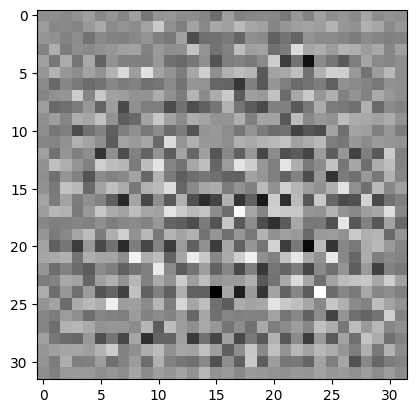

In [ ]:
plt.imshow(generated_image[0,:,:,0],cmap='gray')

In [ ]:
posterior = D(generated_image)

In [ ]:
print(posterior)

tf.Tensor([[0.49998686]], shape=(1, 1), dtype=float32)


In [ ]:
GAN_epochs = 50
noise_shape = 100
batch_size = 256

In [ ]:
import keras
from IPython import display
import numpy as np

In [ ]:
bce_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def D_loss(real_imgs_preds,fake_imgs_preds):

  real_imgs_labels = 0.05 * tf.random.uniform(shape=tf.shape(real_imgs_preds)) + tf.ones_like(real_imgs_preds)
  fake_imgs_labels = 0.05 * tf.random.uniform(shape=tf.shape(fake_imgs_preds)) + tf.zeros_like(fake_imgs_preds)

  real_imgs_bce_loss = bce_loss(y_true=real_imgs_labels,y_pred=real_imgs_preds)
  fake_imgs_bce_loss = bce_loss(y_true=fake_imgs_labels,y_pred=fake_imgs_preds)

  total_loss = real_imgs_bce_loss + fake_imgs_bce_loss

  return total_loss

In [ ]:
def G_loss(fake_imgs_preds):

  fake_imgs_labels = tf.ones_like(fake_imgs_preds)

  return bce_loss(y_true=fake_imgs_labels,y_pred=fake_imgs_preds)

In [ ]:
D_optimizer = keras.optimizers.Adam(learning_rate=0.0008,beta_1=0.3)
G_optimizer = keras.optimizers.Adam(learning_rate=0.0004,beta_1=0.1)

In [ ]:
GAN_checkpoint_dir = "/content/drive/MyDrive/GAN_training_checkpoints"
GAN_checkpoint_prefix = os.path.join(GAN_checkpoint_dir,"ckpt")
GAN_checkpoint = tf.train.Checkpoint(optimizer=[D_optimizer,G_optimizer],model=[D,G])

In [ ]:
@tf.function
def training_step(real_imgs_mini_batch):

  G.trainable = False
  noise = tf.random.normal(shape=(batch_size,noise_shape))
  generated_imgs_mini_batch = G(noise,training=False)

  D.trainable = True

  with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape:

    real_imgs_preds = D(real_imgs_mini_batch,training=True)
    fake_imgs_preds = D(generated_imgs_mini_batch,training=True)

    disc_loss = D_loss(real_imgs_preds,fake_imgs_preds)

    gradients_of_disc = disc_tape.gradient(disc_loss,D.trainable_variables)
    D_optimizer.apply_gradients(zip(gradients_of_disc,D.trainable_variables))

    D.trainable = False
    G.trainable = True

    #noise = tf.random.normal(shape=(batch_size,noise_shape))
    #generated_imgs_mini_batch = G(noise,training=True)

    #fake_imgs_preds = D(generated_imgs_mini_batch,training=False)

    gen_loss = G_loss(fake_imgs_preds)

    gradients_of_gen = gen_tape.gradient(gen_loss,G.trainable_variables)
    G_optimizer.apply_gradients(zip(gradients_of_gen,G.trainable_variables))

    print("Ran Training Step")

    return disc_loss,gen_loss

In [ ]:
constant_noise = tf.random.normal(shape=(16,noise_shape))

In [ ]:
def generate_and_save_images(generator_model,epoch,test_input):

  generated_sample_images = generator_model(test_input,training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(generated_sample_images.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(generated_sample_images[i,:,:,:])
    plt.axis("off")

  plt.savefig("Images_at_Epoch_{:04d}.png".format(epoch))
  plt.show()

In [ ]:
real_imgs_path = "/content/drive/MyDrive/datasets_ML/MelanomaDetection/MelanomaDetection/unlabeled"

In [ ]:
def train_gan(real_imgs_datagen,total_epochs):

  for epoch in range(total_epochs):

    time_step = 1

    for image_batch in real_imgs_datagen:

      print("Time Step: {}, Epoch: {}".format(time_step,epoch+1))

      with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape:

        G.trainable = False
        noise = tf.random.normal(shape=(batch_size,noise_shape))
        generated_imgs_mini_batch = G(noise,training=False)

        D.trainable = True

        real_imgs_preds = D(image_batch[0],training=True)
        fake_imgs_preds = D(generated_imgs_mini_batch,training=True)

        disc_loss = D_loss(real_imgs_preds,fake_imgs_preds)

        gradients_of_disc = disc_tape.gradient(disc_loss,D.trainable_variables)
        D_optimizer.apply_gradients(zip(gradients_of_disc,D.trainable_variables))

        D.trainable = False
        G.trainable = True

        #noise = tf.random.normal(shape=(batch_size,noise_shape))
        #generated_imgs_mini_batch = G(noise,training=True)

        #fake_imgs_preds = D(generated_imgs_mini_batch,training=False)

        gen_loss = G_loss(fake_imgs_preds)

        gradients_of_gen = gen_tape.gradient(gen_loss,G.trainable_variables)
        G_optimizer.apply_gradients(zip(gradients_of_gen,G.trainable_variables))

        print("Discriminator Loss: {}, Generator Loss: {}\n".format(disc_loss,gen_loss))

      if time_step > len(os.listdir(real_imgs_path))//batch_size:
        break

      time_step = time_step + 1

    generate_and_save_images(generator_model=G,epoch=epoch+1,test_input=constant_noise)

    if (epoch + 1) % 5 == 0:
      GAN_checkpoint.save(file_prefix=GAN_checkpoint_prefix)

  generate_and_save_images(generator_model=G,epoch=total_epochs,test_input=constant_noise)

In [ ]:
#train_gan(real_imgs_datagen=unlabeled_datagen,total_epochs=GAN_epochs)

In [ ]:
latest_checkpoint_path = tf.train.latest_checkpoint("/content/drive/MyDrive/GAN_training_checkpoints")

In [ ]:
latest_checkpoint_path

'/content/drive/MyDrive/GAN_training_checkpoints/ckpt-10'

In [ ]:
GAN_checkpoint.restore(latest_checkpoint_path)

In [ ]:
def generate_and_save_images(generator_model,test_input):

  generated_sample_images = generator_model(test_input,training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(generated_sample_images.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(generated_sample_images[i,:,:,:])
    plt.axis("off")

  plt.show()

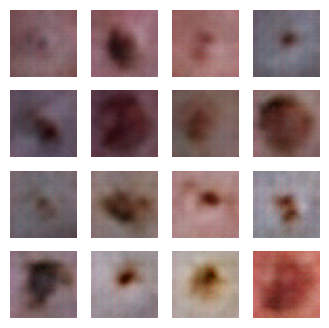

In [ ]:
generate_and_save_images(generator_model=G,test_input=constant_noise)

In [ ]:
unlbld_imgs_base_path = "/content/drive/MyDrive/datasets_ML/MelanomaDetection/MelanomaDetection/unlabeled"

In [ ]:
from random import randint

In [ ]:
imgs_names_list = os.listdir(unlbld_imgs_base_path)

In [ ]:
total_imgs = len(imgs_names_list)

In [ ]:
single_img = plt.imread(os.path.join(unlbld_imgs_base_path,imgs_names_list[randint(0,total_imgs-1)]))

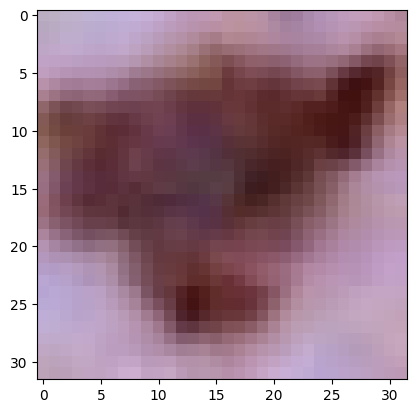

In [ ]:
plt.imshow(single_img)

In [ ]:
single_fake_img = G(tf.random.normal(shape=(1,100)))

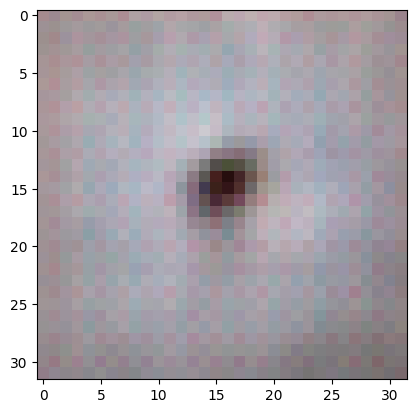

In [ ]:
plt.imshow(single_fake_img[0,:,:,:])

In [ ]:
from keras.models import Model

In [ ]:
def discriminator_base():

  input_to_cls = Input(shape=(32,32,3))

  disc_base = Sequential(name="disc_base")
  disc_base.add(input_to_cls)


  """
  set_trainable = False

  for layer in D.layers:
    if layer.name == 'conv2d_2':
      set_trainable = True
    if set_trainable:
      layer.trainable = True
    else:
      layer.trainable = False
  """

  for layer in D.layers[0:9]:
    layer.trainable = False
    disc_base.add(layer)

  return disc_base

In [ ]:
def unsupervised_classifier():

  disc_base = discriminator_base()

  #disc_base_unsupervised_cls = Dropout(rate=0.6)(disc_base.output)

  disc_base_unsupervised_cls = Dense(units=1,activation="sigmoid")(disc_base.output)

  unsupervised_cls = Model(inputs=disc_base.input,outputs=disc_base_unsupervised_cls)

  return unsupervised_cls

In [ ]:
def supervised_classifier():

  disc_base = discriminator_base()

  disc_base_supervised_cls = Dropout(rate=0.7)(disc_base.output)

  disc_base_supervised_cls = Dense(units=1,activation="sigmoid")(disc_base_supervised_cls)

  supervised_cls = Model(inputs=disc_base.input,outputs=disc_base_supervised_cls)

  #supervised_cls.compile()

  return supervised_cls

In [ ]:
unsupervised_cls = unsupervised_classifier()
supervised_cls = supervised_classifier()

In [ ]:
unsupervised_cls_optimizer = keras.optimizers.Adam(learning_rate=0.0001,beta_1=0.5)
supervised_cls_optimizer = keras.optimizers.Adam(learning_rate=0.0001,beta_1=0.5)

In [ ]:
supervised_cls_train_acc_metric = tf.keras.metrics.BinaryAccuracy()
supervised_cls_cv_acc_metric = tf.keras.metrics.BinaryAccuracy()

In [ ]:
def unsupervised_cls_loss(real_imgs_preds,fake_imgs_preds):

  real_imgs_labels = tf.ones_like(real_imgs_preds)
  fake_imgs_labels = tf.zeros_like(fake_imgs_preds)

  real_imgs_loss = bce_loss(y_true=real_imgs_labels,y_pred=real_imgs_preds)
  fake_imgs_loss = bce_loss(y_true=fake_imgs_labels,y_pred=fake_imgs_preds)

  total_loss = real_imgs_loss + fake_imgs_loss

  return total_loss

In [ ]:
def supervised_cls_loss(imgs_labels,imgs_preds):

  imgs_labels = imgs_labels.reshape(imgs_labels.shape[0],1)

  return bce_loss(y_true=imgs_labels,y_pred=imgs_preds)

In [ ]:
@tf.function
def ssl_training_step(labeled_images,unlabeled_images):

  G.trainable = False
  unsupervised_cls.trainable = True
  supervised_cls.trainable = True

  with tf.GradientTape() as supervised_cls_tape, tf.GradientTape() as unsupervised_cls_tape, tf.GradientTape() as gen_tape:

    labeled_imgs_preds = supervised_cls(labeled_images[0],training=True)

    supervised_loss = supervised_cls_loss(imgs_labels=labeled_images[1],imgs_preds=labeled_imgs_preds)

    gradients_of_supervised_cls = supervised_cls_tape.gradient(supervised_loss,supervised_cls.trainable_variables)
    supervised_cls_optimizer.apply_gradients(zip(gradients_of_supervised_cls,supervised_cls.trainable_variables))

    noise = tf.random.normal(shape=(batch_size,noise_shape))
    generated_images = G(noise,training=False)

    real_imgs_preds = unsupervised_cls(unlabeled_images,training=True)
    fake_imgs_preds = unsupervised_cls(generated_images,training=True)

    unsupervised_loss = unsupervised_cls_loss(real_imgs_preds,fake_imgs_preds)

    gradients_of_unsupervised_cls = unsupervised_cls_tape.gradient(unsupervised_loss,unsupervised_cls.trainable_variables)
    unsupervised_cls_optimizer.apply_gradients(zip(gradients_of_unsupervised_cls,unsupervised_cls.trainable_variables))

    supervised_cls.trainable = False
    unsupervised_cls.trainable = False

  return supervised_loss,labeled_imgs_preds

In [ ]:
cls_checkpoint_dir = "/content/drive/MyDrive/Colab Notebook/cls_Melanoma_training_checkpoints"
checkpoint_prefix = os.path.join(cls_checkpoint_dir,"ckpt")
cls_checkpoint = tf.train.Checkpoint(optimizer=[supervised_cls_optimizer,unsupervised_cls_optimizer],
                                     model=[supervised_cls,unsupervised_cls])

In [ ]:
import shutil

Used Below code to diffrentiate diffrent class labels got image name and put in their respective folders for ImageDataGenerator

In [ ]:
def move_files():
  dir = "/content/MelanomaDetection/MelanomaDetection/test"

  files = os.listdir(dir)
  #os.mkdir("/content/drive/MyDrive/datasets_ML/MelanomaDetection/MelanomaDetection/test/malignant")
  #os.mkdir("/content/drive/MyDrive/datasets_ML/MelanomaDetection/MelanomaDetection/test/benign")
  destn_benign = "/content/drive/MyDrive/datasets_ML/MelanomaDetection/MelanomaDetection/test/benign/"
  destn_malignant = "/content/drive/MyDrive/datasets_ML/MelanomaDetection/MelanomaDetection/test/malignant/"
  for singleFile in files:
    basename = os.path.basename(singleFile)
    file_class = (os.path.splitext(basename)[0]).split("_")[1]
    if int(file_class) ==0:
      old_path = os.path.join(dir,basename)
      new_path = os.path.join(destn_benign,basename)
      shutil.copyfile(old_path,new_path)
    else:
      old_path = os.path.join(dir,basename)
      new_path = os.path.join(destn_malignant,basename)
      shutil.copyfile(old_path,new_path)
  return 1

In [ ]:
#!unzip "/content/drive/MyDrive/datasets_ML/MelanomaDetection.zip" > /dev/null

In [ ]:
cls_epochs = 100

In [ ]:
cv_data_gen = ImageDataGenerator(rescale=1.0/255.0,validation_split=0.50)

In [ ]:
cv_datagen = cv_data_gen.flow_from_directory(directory="/content/drive/MyDrive/datasets_ML/MelanomaDetection/MelanomaDetection/test",
                                             target_size=(32,32),
                                             classes=os.listdir("/content/drive/MyDrive/datasets_ML/MelanomaDetection/MelanomaDetection/test"),
                                             class_mode="binary",batch_size=150,subset="validation")

Found 300 images belonging to 2 classes.


In [ ]:
test_datagen = cv_data_gen.flow_from_directory(directory="/content/drive/MyDrive/datasets_ML/MelanomaDetection/MelanomaDetection/test",
                                             target_size=(32,32),
                                             classes=os.listdir("/content/drive/MyDrive/datasets_ML/MelanomaDetection/MelanomaDetection/test"),
                                             class_mode="binary",batch_size= 150,subset="training")

Found 300 images belonging to 2 classes.


In [ ]:
labeled_data_gen = ImageDataGenerator(rotation_range=90,brightness_range=(0.5,1),horizontal_flip=True,vertical_flip=True,rescale=1.0/255.0
                                      )

In [ ]:
labeled_datagen = labeled_data_gen.flow_from_directory(directory="/content/drive/MyDrive/datasets_ML/MelanomaDetection/MelanomaDetection/labeled",
                                                       target_size=(32,32),
                                                       classes= os.listdir("/content/drive/MyDrive/datasets_ML/MelanomaDetection/MelanomaDetection/labeled"),
                                                       class_mode="binary",batch_size=7)

Found 200 images belonging to 2 classes.


In [ ]:
def train_ssl_classifier(labeled_imgs_datagen,unlabeled_imgs_datagen,cv_imgs_datagen,total_epochs):

  for epoch in range(total_epochs):

    time_step = 1

    for labeled_images_batch, unlabeled_images_batch in zip(labeled_imgs_datagen,unlabeled_imgs_datagen):

      with tf.GradientTape() as supervised_cls_tape, tf.GradientTape() as unsupervised_cls_tape, tf.GradientTape() as gen_tape:

        G.trainable = False
        #unsupervised_cls.trainable = True
        #supervised_cls.trainable = True

        labeled_imgs_preds = supervised_cls(labeled_images_batch[0],training=True)

        supervised_loss = supervised_cls_loss(imgs_labels=labeled_images_batch[1],imgs_preds=labeled_imgs_preds)

        gradients_of_supervised_cls = supervised_cls_tape.gradient(supervised_loss,supervised_cls.trainable_variables)
        supervised_cls_optimizer.apply_gradients(zip(gradients_of_supervised_cls,supervised_cls.trainable_variables))

        noise = tf.random.normal(shape=(batch_size,noise_shape))
        generated_images = G(noise,training=False)

        real_imgs_preds = unsupervised_cls(unlabeled_images_batch[0],training=True)
        fake_imgs_preds = unsupervised_cls(generated_images,training=True)

        unsupervised_loss = unsupervised_cls_loss(real_imgs_preds,fake_imgs_preds)

        gradients_of_unsupervised_cls = unsupervised_cls_tape.gradient(unsupervised_loss,unsupervised_cls.trainable_variables)
        unsupervised_cls_optimizer.apply_gradients(zip(gradients_of_unsupervised_cls,unsupervised_cls.trainable_variables))

        #supervised_cls.trainable = False
        #unsupervised_cls.trainable = False

      if time_step > len(os.listdir("/content/drive/MyDrive/datasets_ML/MelanomaDetection/MelanomaDetection/unlabeled"))//batch_size:
        break

      supervised_cls_train_acc_metric.update_state(labeled_images_batch[1],labeled_imgs_preds)
      print("Training Loss at Time Step {} of Epoch {} is {}".format(time_step,epoch+1,float(supervised_loss)))

      time_step = time_step + 1

    training_accuracy = supervised_cls_train_acc_metric.result()
    print("\nTraining Accuracy after Epoch {} is {}".format(epoch+1,float(training_accuracy)))

    supervised_cls_train_acc_metric.reset_states()

    cv_time_steps = 0

    for X_cv,Y_cv_labels in cv_imgs_datagen:

      if cv_time_steps > 300//150:
        break

      cv_time_steps = cv_time_steps + 1

      Y_cv_preds = supervised_cls(X_cv,training=False)
      supervised_cls_cv_acc_metric.update_state(Y_cv_labels,Y_cv_preds)

    cv_accuracy = supervised_cls_cv_acc_metric.result()
    print("Corss Validation Accuracy after Epoch {} is {}\n".format(epoch+1,float(cv_accuracy)))

    supervised_cls_cv_acc_metric.reset_states()
    if (epoch +1)%2==0:
      cls_checkpoint.save(file_prefix=checkpoint_prefix)

In [ ]:
#train_ssl_classifier(labeled_imgs_datagen=labeled_datagen,unlabeled_imgs_datagen=unlabeled_datagen, cv_imgs_datagen=cv_datagen,total_epochs=cls_epochs)

In [ ]:
ssl_checkpoint_path = tf.train.CheckpointManager(checkpoint=cls_checkpoint,directory= "/content/drive/MyDrive/Colab Notebook/cls_Melanoma_training_checkpoints",max_to_keep=50)

In [ ]:
#if we want to restore the whatever epoch - index number want to restore
#cls_checkpoint.restore("/content/drive/MyDrive/Colab Notebook/cls_Melanoma_training_checkpoints/ckpt-50.index")

In [ ]:
cls_checkpoint.restore(ssl_checkpoint_path.latest_checkpoint)

In [ ]:
#tf.nn.sigmoid_cross_entropy_with_logits(logits=final_val,labels=test_datagen[0][1].reshape((150,1)))
supervised_cls_test_acc_metric = tf.keras.metrics.BinaryAccuracy()

Testing Data accuracy for melanoma detection

In [ ]:
time_step = 1
for X_test,Y_test_labels in test_datagen:

  if time_step > 300//150:
    break

  time_step = time_step + 1

  Y_test_preds = supervised_cls(X_test,training=False)
  supervised_cls_test_acc_metric.update_state(Y_test_labels,Y_test_preds)

test_accuracy = supervised_cls_test_acc_metric.result()
print(test_accuracy)

tf.Tensor(0.74, shape=(), dtype=float32)
